# Amortized neural inference using NeuralEstimators

**Author: Matthew Sainsbury-Dale**

The package **NeuralEstimators** facilitates a suite of neural methods for parameter inference in scenarios where simulation from the model is feasible. The package is native to [Julia](https://msainsburydale.github.io/NeuralEstimators.jl/dev/) but also features an R interface available on [CRAN](https://cran.r-project.org/web/packages/NeuralEstimators/index.html). It supports:

- Neural Bayes estimators (NBEs), which transform data into functionals of the posterior distribution;
- Neural posterior estimators (NPEs), which perform approximate posterior inference via KL-divergence minimization; and
- Neural ratio estimators (NREs), which approximate the likelihood-to-evidence ratio and thereby enable frequentist or Bayesian inference through various downstream algorithms.

These methods are **simulation-based/likelihood-free**, in the sense that they do not require evaluation or knowledge of the likelihood function. They are also **amortized**, in the sense that, once the neural networks are trained on simulated data, they enable rapid inference across arbitrarily many observed data sets in a fraction of the time required by conventional approaches. See Zammit-Mangion et al. (2025) for a recent review of neural inferential methods.

In this workshop, we will demonstrate basic usage of the package by constructing an NBE and an NPE to make inferences from gridded spatial data.

## Environment and software dependencies

The workshop is intended to be conducted using Google Colab. If you haven't already opened this notebook file in Google Colab, please visit [https://colab.research.google.com/](https://colab.research.google.com/), click `Upload` $\rightarrow$ `Browse`, then upload this notebook file.

Next, we need to tell Google Colab to use `Julia`. To do this, click `Runtime` $\rightarrow$ `Change runtime type`, and select `Julia` from the `Runtime type` dropdown menu. We only need the CPU for this workshop, so leave `Hardware accelerator` set to `CPU`. Finalize the runtime settings by clicking `Save`.

Once this is done, we can install the software dependencies by running the following code blocks. To run a code block, click on the cell and press `Shift + Enter` on your keyboard, "queuing" multiple blocks by pressing these keys multiple times (note that this installation step takes about 10 minutes):

In [1]:
# Set to true to enable GPU acceleration (requires an NVIDIA GPU and CUDA;
# we use the CPU in this workshop due to Colab installation time)
install_cuda = false

false

In [2]:
# Install Julia packages
using Pkg
Pkg.add("Flux")
Pkg.add("BSON")

# Visualization (NB: will remove "AlgebraOfGraphics", "CairoMakie" once we've
# changed the internal plotting functions to use Plots.jl)
Pkg.add(["Plots", "StatsPlots", "AlgebraOfGraphics", "CairoMakie"])
Pkg.add(["Downloads", "RData"]) # loading presimulated draws from 𝑝(𝜃, 𝐙)

Pkg.add(url = "https://github.com/msainsburydale/NeuralEstimators.jl", rev="workshop")

if install_cuda
  Pkg.add("CUDA")
end

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed InitialValues ─────── v0.3.1
   Installed RealDot ───────────── v0.1.0
   Installed PrettyPrint ───────── v0.2.0
   Installed ZygoteRules ───────── v0.2.7
   Installed ContextVariablesX ─── v0.1.3
   Installed ShowCases ─────────── v0.1.0
   Installed Accessors ─────────── v0.1.43
   Installed MLUtils ───────────── v0.4.8
   Installed DefineSingletons ──── v0.1.2
   Installed MicroCollections ──── v0.2.0
   Installed ProgressLogging ───── v0.1.6
   Installed OneHotArrays ──────── v0.2.10
   Installed IRTools ───────────── v0.4.15
   Installed FLoopsBase ────────── v0.1.1
   Installed MLCore ────────────── v1.0.0
   Installed Zygote ────────────── v0.7.10
   Installed ChainRules ────────── v1.73.0
   Installed NameResolution ────── v0.1.5
   Installed ArgCheck ──────────── v2.5.0
   Installed Transducers ───────── v0.4.85
   Installed CompositionsBase ──── v0.1.2
   Installed BangBa

In [58]:
# Load Julia packages
using Flux
using BSON: @load
using NeuralEstimators
using Plots, StatsPlots, AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: plot # NB: will remove once we've changed the internal plotting functions to use Plots.jl
using Downloads, RData
using Downloads: download
using Statistics

# If using a GPU, load CUDA and check that the GPU is functional
if install_cuda
  using CUDA
  CUDA.functional()
end

## Part 1: Constructing a neural estimator for gridded spatial data

In this workshop, we illustrate the basic workflow of **NeuralEstimators** by developing an NBE for gridded spatial data.

We consider a Markov random field (e.g., Cressie, 1993, Ch. 6; Rue and Held, 2005) known as the Potts (1952) model. Consider a regular grid of pixels indexed by $i = 1, \dots, n$, where each pixel takes on a label $Z_i$ from a finite set of discrete states $\{1, \dots, Q\}$. Define $\mathbf{Z} \equiv (Z_1, \dots, Z_n)'$. Then, the Potts model is specified through the conditional distributions,  
$$
 {\rm{Pr}}(Z_i = z \mid \mathbf{Z}_{\backslash i}, \theta) \propto \exp\Big\{\theta \sum_{j \in \mathscr{N}_i} \mathbb{I}(Z_j = z)\Big\}, \; \text{for } z \in \{1, \dots, Q\},
$$
where $\mathbf{Z}_{\backslash i}$ denotes all pixel labels excluding pixel $i$; $\theta > 0$ is a parameter controlling the strength of spatial dependence; and $\mathscr{N}_i$ contains the indices of the "neighbors" of pixel $i$. Here, we let the neighbors $\mathscr{N}_i$ be the adjacent pixels of pixel $i$, with four neighbors for interior pixels, three for edge pixels, and two for corner pixels. The Potts model exhibits a phase transition at the critical parameter value $\theta_c = \log(1 + \sqrt{Q})$, transitioning from disorder when $\theta < \theta_c$ (where most neighboring pixels do not have the same label) to order when $\theta > \theta_c$ (most neighboring pixels have the same label).

The Potts model is an ideal candidate for simulation-based/likelihood-free inference, since its likelihood function involves a computationally intractable normalizing constant, but simulation can be done quickly using Gibbs sampling.

We consider the Potts model with $Q = 2$ states, a special case known as the Ising (1925) model.

### Step 1: Defining functions to sample from the prior and simulate from the model

The first step of the workflow is to define functions for sampling parameters from the prior $p(\theta)$ and simulating from the model $p(\mathbf{Z} \mid \theta)$ conditional on the parameters.

For the Ising model, the critical parameter value is $\theta_c = \log(1 + \sqrt{2}) = 0.881$. Therefore, to construct an estimator that can be used for a broad range of scenarios, we adopt the prior $\theta \sim \rm{Unif}(0.01, 1.5)$.

To simulate from the model, we use a simple Gibbs sampler implemented in **NeuralEstimators**.

In [4]:
# Sampling from the prior distribution
# N: number of samples to draw from the prior
function prior(N)
    theta = rand(N) .* (1.5 - 0.05) .+ 0.05  # uniform(0.05, 1.5)
    return theta'  # return as matrix
end

# Marginal simulation from the statistical model
# theta: a matrix of parameters drawn from the prior
function simulate(theta; nrows = 150, ncols = 150, num_states = 2)


    # Simulate all data sets
    Z = map(1:size(theta, 2)) do i
        β = theta[:, i]
        simulatepotts(nrows, ncols, num_states, β; num_iterations = 250)
    end

    # Combine into a single 4D array, with independent data sets stored in the final dimension
    # Format: height × width × channels × batch_size
    Z_array = cat([reshape(z, nrows, ncols, 1, 1) for z in Z]..., dims=4)

    return Z_array
end

simulate (generic function with 1 method)

Note that when working with the package **NeuralEstimators**, the following general rules regarding assumed data format apply:

- Parameters are always stored as matrices, where each column corresponds to one parameter vector $\boldsymbol{\theta}$ (in this workshop, we have only a single parameter, $\theta$);  
- Simulated data sets are stored as mini-batches in a format amenable to the chosen neural-network architecture.

For data collected on a two-dimensional grid (as in this workshop), the estimator is typically based on a convolutional neural network (CNN) and the observations are arranged in a four-dimensional array, where the final dimension indexes independent data sets.

Let's visualize some realizations from the model, using our simulation function defined above. We'll visualize realizations corresponding to the parameters $\theta \in \{0.2, 0.45, 0.7, 0.881, 1.0, 1.2, 1.4\}$ to illustrate the phase transition that occurs at $\theta_c = 0.881$:

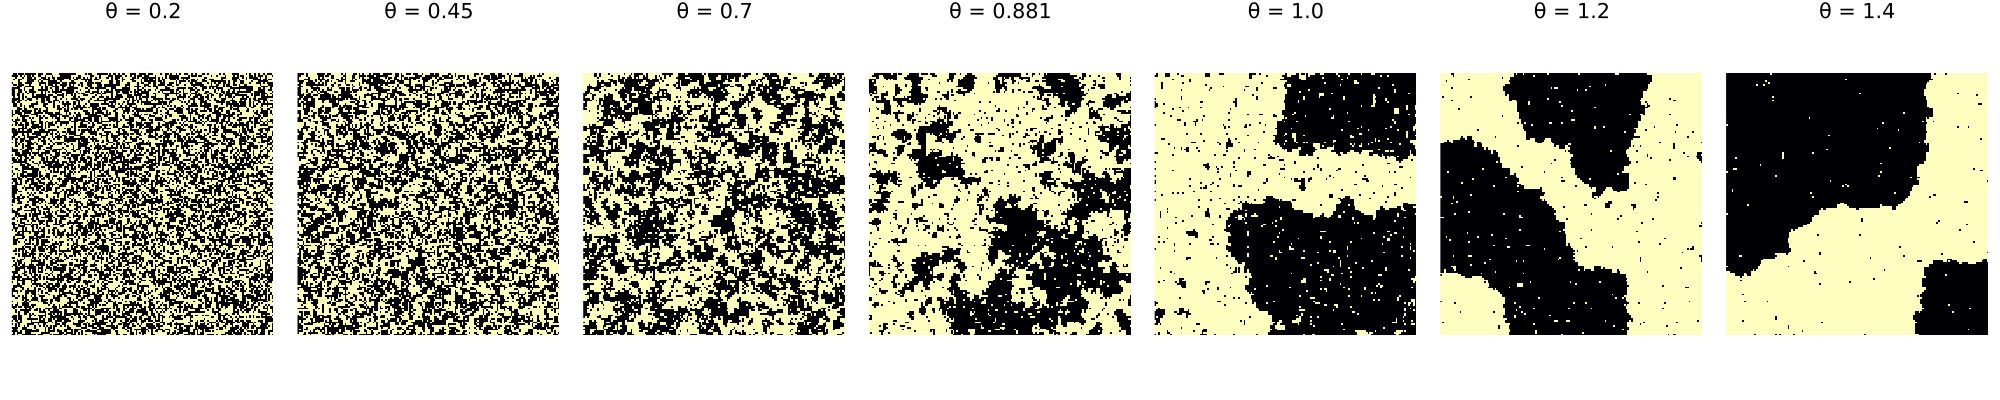

In [5]:
# True parameter values
theta = [0.2 0.45 0.7 0.881 1.0 1.2 1.4]

# Simulations
Z = simulate(theta)

# Create plots for each theta value
plots_array = []
for k in 1:size(theta, 2)
    z = Z[:, :, 1, k]
    p = Plots.heatmap(z', c=:magma,
                title="θ = $(theta[k])",
                colorbar=false,
                aspect_ratio=:equal,
                axis=nothing,
                border=:none,
                framestyle=:none)
    push!(plots_array, p)
end

# Combine into single plot
Plots.plot(plots_array..., layout=(1, 7), size=(2000, 400))

### Step 2: Constructing training/validation/testing sets

We now draw realizations from the joint distribution $p(\theta, \mathbf{Z}) = p(\theta)p(\mathbf{Z} \mid \theta)$, which are used to (i) optimize the neural-network parameters via stochastic gradient descent (training set), (ii) monitor the performance of the network during training (validation set), and (iii) assess the network post training (test set).

To save time in this workshop, we make available 10,000 pre-simulated draws from $p(\theta, \mathbf{Z})$. These can be downloaded as follows:

In [34]:
# Download the draws from p(θ, Z)
workshop_url = "https://raw.githubusercontent.com/msainsburydale/NeuralIncompleteData/main/workshop/"
download(workshop_url * "parameter_draws.rds", "parameter_draws.rds")
download(workshop_url * "data_draws.rds", "data_draws.rds")

# Load the draws into Julia
theta = load("parameter_draws.rds")
Z = load("data_draws.rds")
size(Z)

(150, 150, 1, 10000)

The downloaded draws can then be partitioned into training, validation, and test sets as follows:

In [32]:
# Split the draws from p(θ, Z) into training, validation, and test sets
N = 1000                            # size of the training/validation sets
N_test = 500                        # size of the test set
@assert 2 * N + N_test <= 10000     # check that we don't exceed the available 10,000 draws
idx_train = 1:N
idx_val   = (N+1):(2*N)
idx_test  = (2*N+1):(2*N + N_test)

theta_train = theta[:, idx_train]   # parameter vectors used in stochastic-gradient descent during training
theta_val   = theta[:, idx_val]     # parameter vectors used to monitor performance during training
theta_test  = theta[:, idx_test]    # parameter vectors used to test performance post training

Z_train = Z[:, :, :, idx_train]     # data used in stochastic-gradient descent during training
Z_val   = Z[:, :, :, idx_val]       # data used to monitor performance during training
Z_test  = Z[:, :, :, idx_test];      # data used to test performance post training

### Step 3: Designing the neural-network architecture

Next we design and initialize a suitable neural network. The architecture class (e.g., MLP, CNN, GNN) should align with the multivariate structure of the data (e.g., unstructured, grid, graph). The specific input and output spaces depend on the chosen inferential method:

- For NBEs, the neural network is a mapping $\mathscr{Z}\to\Theta$, where $\mathscr{Z}$ denotes the sample space and $\Theta$ denotes the parameter space.
- For NPEs, the neural network is a mapping $\mathscr{Z}\to \mathbb{R}^{d^*}$, where $\mathbb{R}^{d^*}$ is an appropriate number of summary statistics for the given parameter vector (often $d^* = d$ is suitable). Internally, these learned summary statistics are then mapped to the space of approximate-distribution parameters using a second, internally constructed neural network.
    
Any [Flux](https://fluxml.ai/Flux.jl/stable/) model can be used to construct the neural network. Given $N$ data sets stored appropriately, the neural network should output a matrix with $N$ columns, where the number of rows corresponds to the dimensionality of the output spaces listed above.

This is the only step that requires users to write Julia/Flux code. While this design choice provides maximum flexibility for defining custom neural-network architectures, it does require some familiarity with neural-network design and basic Julia/Flux programming.

Since our data are gridded, we employ a CNN architecture. A global mean pooling layer ensures that the network can be used with grids of arbitrary dimension. (Technically the architecture below requires a minimum grid dimension of 8, but this can be easily changed by modifying the sequence of convolutional and local pooling layers prior to global pooling.)

In [27]:
# Number of unknown parameters
d = size(theta_train, 1)

# CNN architecture
# Input: H × W × 1 (univariate spatial field)
network = Chain(
    Conv((3, 3), 1 => 16, pad=1, relu),   # → H × W × 16
    MaxPool((2, 2)),                      # → (H/2) × (W/2) × 16
    Conv((3, 3), 16 => 32, pad=1, relu),  # → (H/2) × (W/2) × 32
    MaxPool((2, 2)),                      # → (H/4) × (W/4) × 32
    Conv((3, 3), 32 => 64, pad=1, relu),  # → (H/4) × (W/4) × 64
    MaxPool((2, 2)),                      # → (H/8) × (W/8) × 64
    Conv((3, 3), 64 => 128, pad=1, relu), # → (H/8) × (W/8) × 128
    GlobalMeanPool(),                     # → 1 × 1 × 128
    Flux.flatten,                         # → 128-dimensional vector
    Dense(128, 128),                      # → 128-dimensional vector
    Dense(128, d)                         # → d-dimensional output vector
)

Chain(
  Conv((3, 3), 1 => 16, relu, pad=1),   # 160 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, relu, pad=1),  # 4_640 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  GlobalMeanPool(),
  Flux.flatten,
  Dense(128 => 128),                    # 16_512 parameters
  Dense(128 => 1),                      # 129 parameters
)                   # Total: 12 arrays, 113_793 parameters, 445.645 KiB.

Now, let's quickly check that the neural network can be applied to our data (i.e. that the format of the data provided by our simulation function conforms with our specified architecture). Note that the output is not meaningful at this stage, since the neural network has not been trained!

In [28]:
# Check that the neural network can be applied to our data
Z_subset = Z_train[:, :, :, 1:10]
estimate(network, Z_subset)

1×10 Matrix{Float32}:
 -0.129017  -0.155422  -0.160799  …  -0.0341068  -0.155192  -0.160809

### Step 4: Initializing the estimator

Once the neural-network architecture has been specified, we wrap the network as a [NeuralEstimator](https://msainsburydale.github.io/NeuralEstimators.jl/dev/API/core/#Estimators) object corresponding to the intended inferential method. For NBEs under general, user-defined loss functions, we use [PointEstimator](https://msainsburydale.github.io/NeuralEstimators.jl/dev/API/core/#NeuralEstimators.PointEstimator); for NPEs, we use [PosteriorEstimator](https://msainsburydale.github.io/NeuralEstimators.jl/dev/API/core/#NeuralEstimators.PosteriorEstimator).


In [29]:
# Initialize the estimator
NBE = PointEstimator(network)

PointEstimator{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, GlobalMeanPool, typeof(Flux.flatten), Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}(Chain(Conv((3, 3), 1 => 16, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 16 => 32, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 32 => 64, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 64 => 128, relu, pad=1), GlobalMeanPool(), flatten, Dense(128 => 128), Dense(128 => 1)))

### Step 5: Training the neural network

Training proceeds with the function [train()](https://msainsburydale.github.io/NeuralEstimators.jl/dev/API/core/#Training).

Note that Julia uses "just-in-time" compilation; the first time that a function is called, it is compiled into fast-executing machine code. Since this is a fresh environment (i.e., no internal functions have yet been compiled), a couple of minutes of compilation are needed before the following command gets going.

Note also that, in Google Colab, console output indicating training progress is only shown once the command has executed, but on local machines this information is made available in real time.

In this workshop, we are training CNNs with relatively large grids: this task is *much, much* faster when performed with a GPU (typically 2-3 orders of magnitude faster than with a CPU). Since we may not have access to a GPU, in the interest of time, the code below uses a very low number of epochs (passes through the training set when doing stochastic gradient descent):

In [30]:
# Train the neural network
NBE = train(
    NBE,
    theta_train,
    theta_val,
    Z_train,
    Z_val,
    epochs = 3,           # maximum number of epochs
    stopping_epochs = 2   # cease training if the risk does not improve in this number of epochs
)

[ Info: Running on CPU


Computing the initial validation risk... Initial validation risk = 0.8926041
Computing the initial training risk... Initial training risk = 0.91549337
Epoch: 1  Training risk: 0.352  Validation risk: 0.147  Learning rate: 5.00E-04  Epoch time: 80.657 seconds
Epoch: 2  Training risk: 0.128  Validation risk: 0.095  Learning rate: 5.00E-04  Epoch time: 38.156 seconds


[ Info: Forcing garbage collection...


Epoch: 3  Training risk: 0.081  Validation risk: 0.09  Learning rate: 3.75E-04  Epoch time: 42.002 seconds


PointEstimator{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, GlobalMeanPool, typeof(Flux.flatten), Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}(Chain(Conv((3, 3), 1 => 16, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 16 => 32, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 32 => 64, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 64 => 128, relu, pad=1), GlobalMeanPool(), flatten, Dense(128 => 128), Dense(128 => 1)))

Since we did a short training run with a small number of samples from $p(\theta, \mathbf{Z})$, the estimator will be far from optimal. Let's instead load a pretrained neural network saved online. This network was trained using a GPU for 100 epochs, taking roughly 20 seconds. This is one of the neat things about amortized neural inference: the neural network need only be trained once, and then it can be shared and reused repeatedly.

In [35]:
# Specify which estimator we are downloading
estimator_file = "NBE.bson"

# Download the file
download(workshop_url * estimator_file, estimator_file)

# Load the trained neural network
model_state = Flux.state(NBE)
@load estimator_file model_state
NBE = Flux.loadmodel!(NBE, model_state)

PointEstimator{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, GlobalMeanPool, typeof(Flux.flatten), Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}(Chain(Conv((3, 3), 1 => 16, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 16 => 32, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 32 => 64, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 64 => 128, relu, pad=1), GlobalMeanPool(), flatten, Dense(128 => 128), Dense(128 => 1)))

### Step 6: Assessing the estimator

It is good practice to evaluate the performance of a trained neural estimator on unseen test data. This evaluation can be performed manually, or using helper functions provided with the package. Below, we use built-in functions to generate a "recovery plot", which compares the estimated parameter values to the true parameters used to simulate the data:

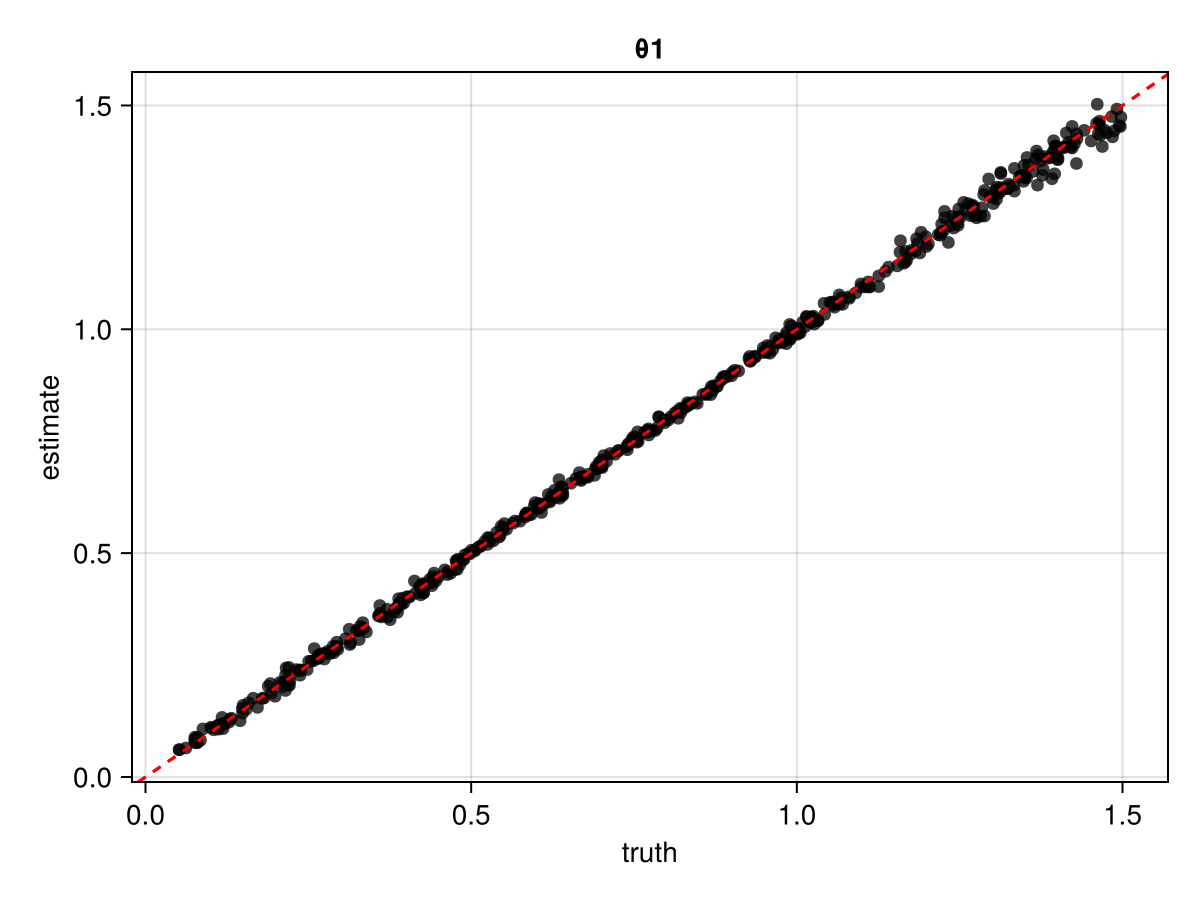

In [38]:
# Assess the estimator with unseen test data
assessment = assess(NBE, theta_test, Z_test)
plot(assessment)

### Step 7: Applying the estimator to observed data

Once the neural estimator has been trained and assessed, it can be
applied repeatedly to data sets that are realizations from the statistical model used during training. NBEs are applied to data using the function [estimate()](https://msainsburydale.github.io/NeuralEstimators.jl/dev/API/core/#NeuralEstimators.estimate), while for NPEs we use [sampleposterior()](https://msainsburydale.github.io/NeuralEstimators.jl/dev/API/core/#NeuralEstimators.sampleposterior).

Of course, the structure of the observed data must conform to the neural-network architecture (in this case, the data must be gridded), and we must be mindful of model misspecification (a topic not covered in this workshop!).

Here, we consider a remote-sensing application with Arctic sea-ice data produced by the National Oceanic and Atmospheric Administration (NOAA) as part of their National Snow and Ice Data Center’s (NSIDC) Climate Data Record. The data are derived from passive microwave remote sensing retrievals from the Nimbus 7 satellite and the F8, F11, F13, and F17 satellites of the Defence Meteorological Satellite Program, projected onto 25km $\times$ 25km grid cells within a region of the Northern Hemisphere spanning longitudes 180°E to 180°W. The data consist of *sea-ice concentrations*, that is, the proportion of sea ice in grid cells at given spatial locations. However, in this workshop, we follow many previous studies on Arctic sea ice and analyze *sea-ice extents*, obtained by applying a 15% threshold to classify a grid cell as "Ice" (ice concentration $\geq$ 15%) or "Not ice" (ice concentration $<$ 15%).

Arctic-sea-ice cover typically reaches its annual minimum in the month of September, and we therefore base our analysis on the ice cover on the first day of September in each year. In September, sea ice does not appear below latitude $60^\circ\text{N}$, and we therefore only consider those grid cells with latitude at or above $60^\circ\text{N}$. Our preprocessed data set comprises 45 spatial images (one image for each year between 1979 and 2023), with each image containing $199\times 219 = 43581$ grid cells, and we analyze each year separately. The preprocessed data set is provided online, and can be downloaded as follows:
  

In [47]:
# Name of the file
dest_file = "sea_ice_extent_complete.rds"

# Download the file
download(workshop_url * dest_file, dest_file)

# Read the .rds object into Julia
sea_ice_extent = load(dest_file)

# Inspect the object
println("Size: ", size(sea_ice_extent))
println("Type: ", typeof(sea_ice_extent))

Size: (199, 219, 1, 45)
Type: Array{Float64, 4}


Note that the data provided by NOAA are incomplete due to natural factors such as cloud cover, as well as technical limitations of the remote-sensing instruments. In this workshop, we analyze a data set that has been "completed" using a simple imputation approach. For more statistically principled methods for dealing with incomplete data in the context of neural inference, see Sainsbury-Dale et al. (2025).

Now, let's visualize the data we'll be working with:

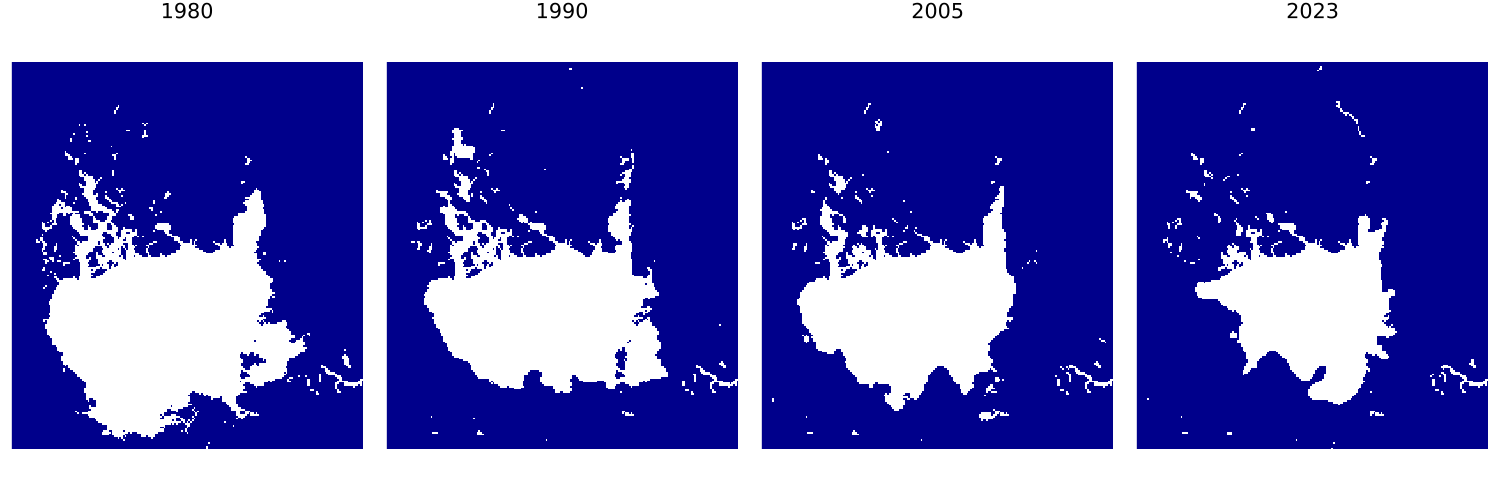

In [48]:
# Visualize the data for several years of interest
years_of_interest = [1980, 1990, 2005, 2023]
idx = years_of_interest .- 1978

plots_array = []
for i in idx
    Z_year = sea_ice_extent[:, :, 1, i]
    p = Plots.heatmap(Z_year',
                c=cgrad([:darkblue, :white]),
                clims=(0, 1),
                title="$(1978 + i)",
                colorbar=false,
                aspect_ratio=:equal,
                axis=nothing,
                border=:none,
                framestyle=:none)
    push!(plots_array, p)
end

Plots.plot(plots_array..., layout=(1, 4), size=(1500, 500))

These data clearly exhibit strong spatial dependence. Let's confirm this by applying our neural estimator trained earlier in the workshop:

In [49]:
# Estimates of the spatial dependence parameter θ for each year between 1978 and 2023
estimates = estimate(NBE, sea_ice_extent)

1×45 Matrix{Float32}:
 1.33528  1.34376  1.31833  1.32774  …  1.41057  1.39915  1.38831  1.39119

Let's plot the estimates as a function of year:

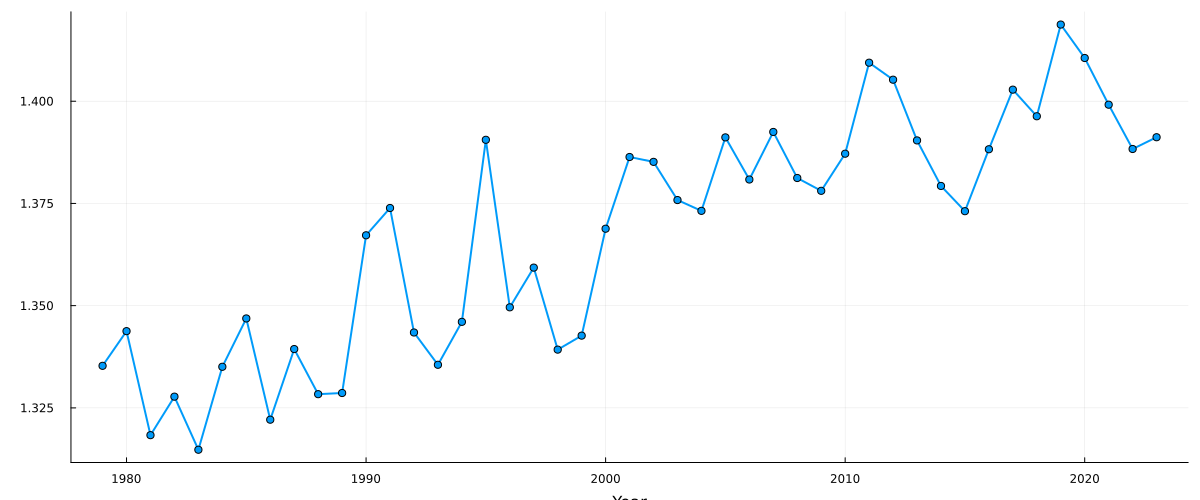

In [51]:
# Plot the estimates as a function of year
years = 1979:2023
Plots.plot(years, vec(estimates),
     xlabel="Year",
     ylabel="θ̂",
     label="",
     marker=:circle,
     linewidth=2,
     size=(1200, 500),
     legend=false)

All estimates are considerably larger than the critical value $\theta_c = 0.881$, confirming a strong tendency for neighboring grid cells to share the same label. Moreover, there is evidence of increasing spatial dependence over time, likely reflecting the shrinking ice sheet and the resulting increase in the proportion of grid cells classified as "Not ice".

## Part 2: Full posterior inference using an NPE

Now that we've constructed and deployed an NBE (i.e., a neural *point* estimator), let's construct an NPE to perform full posterior inference. This can be done with only minor modifications to the code above.

We first modify the estimator class by replacing `PointEstimator(network)` with `PosteriorEstimator(network, d)` in Step 4, and then construct and assess the NPE by re-running Steps 5-6 above.

In [52]:
# Step 4: Initialize the estimator (now using PosteriorEstimator)
NPE = PosteriorEstimator(network, d);

In [40]:
# Step 5: Train the neural network (same as in Part 1)
NPE = train(
    NPE,
    theta_train,
    theta_val,
    Z_train,
    Z_val,
    epochs = 3,
    stopping_epochs = 2
);

[ Info: Running on CPU


Computing the initial validation risk... Initial validation risk = 1.3357952
Computing the initial training risk... Initial training risk = 1.3548615


[ Info: Forcing garbage collection...


Epoch: 1  Training risk: 0.326  Validation risk: -0.109  Learning rate: 5.00E-04  Epoch time: 67.117 seconds


In [53]:
# Optional: Load pretrained network
estimator_file = "NPE.bson"
download(workshop_url * estimator_file, estimator_file)
model_state = Flux.state(NPE)
@load estimator_file model_state
NPE = Flux.loadmodel!(NPE, model_state);

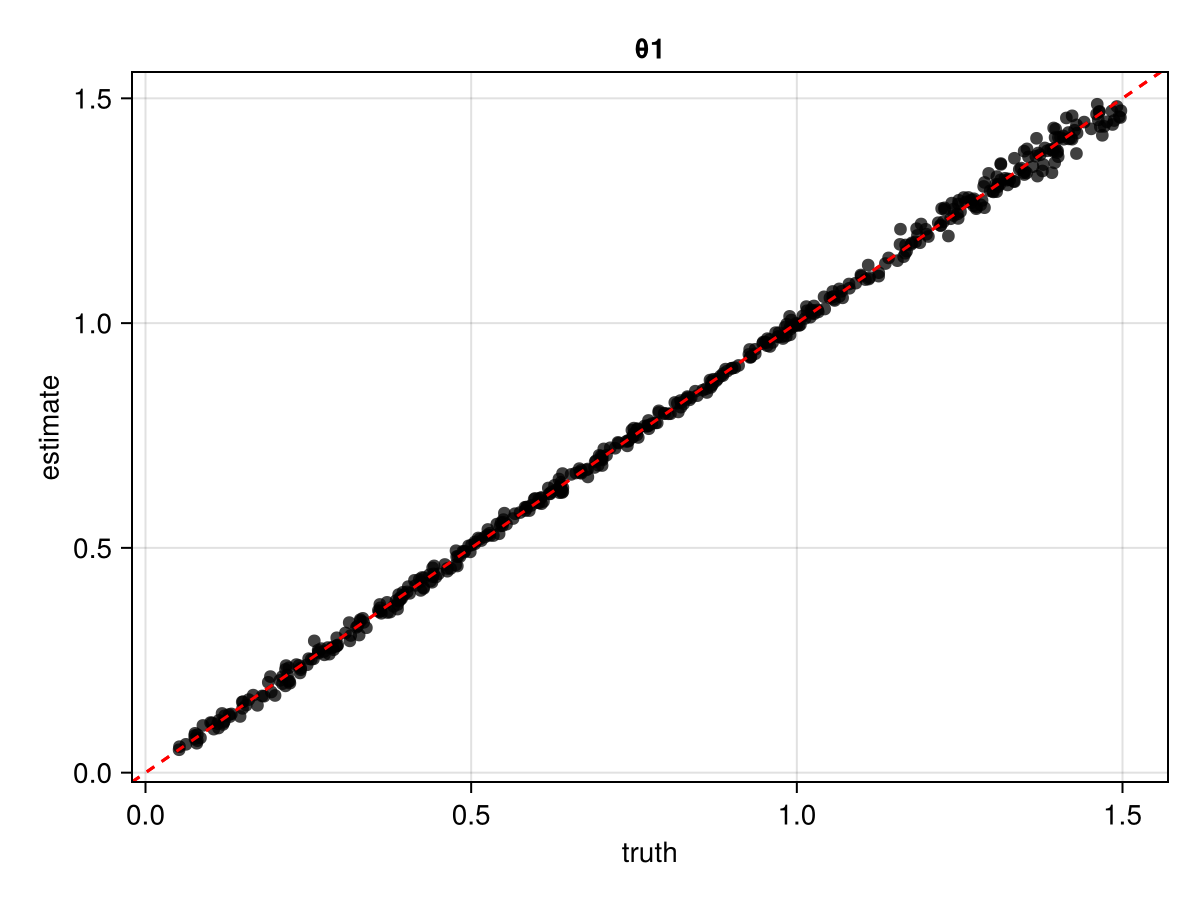

In [54]:
# Step 6: Assess the estimator (same as in Part 1)
assessment = assess(NPE, theta_test, Z_test)
plot(assessment)

Once the NPE is constructed, we can perform approximate posterior inference with the Arctic sea-ice data, using the function [sampleposterior()](https://msainsburydale.github.io/NeuralEstimators.jl/dev/API/core/#NeuralEstimators.sampleposterior):

In [55]:
# Compute posterior samples; returns a vector of matrices,
# where each matrix is d × M (d is the dimension of θ and M is the number of posterior draws)
# for each data set
posterior_samples = sampleposterior(NPE, sea_ice_extent)
println("Type: ", typeof(posterior_samples))
println("Number of years: ", length(posterior_samples))
println("Size of first posterior sample matrix: ", size(posterior_samples[1]))

Type: Vector{Matrix{Float32}}
Number of years: 45
Size of first posterior sample matrix: (1, 1000)


Now that we have posterior samples for each year, let's plot histograms of the posterior samples corresponding to the years visualized above:

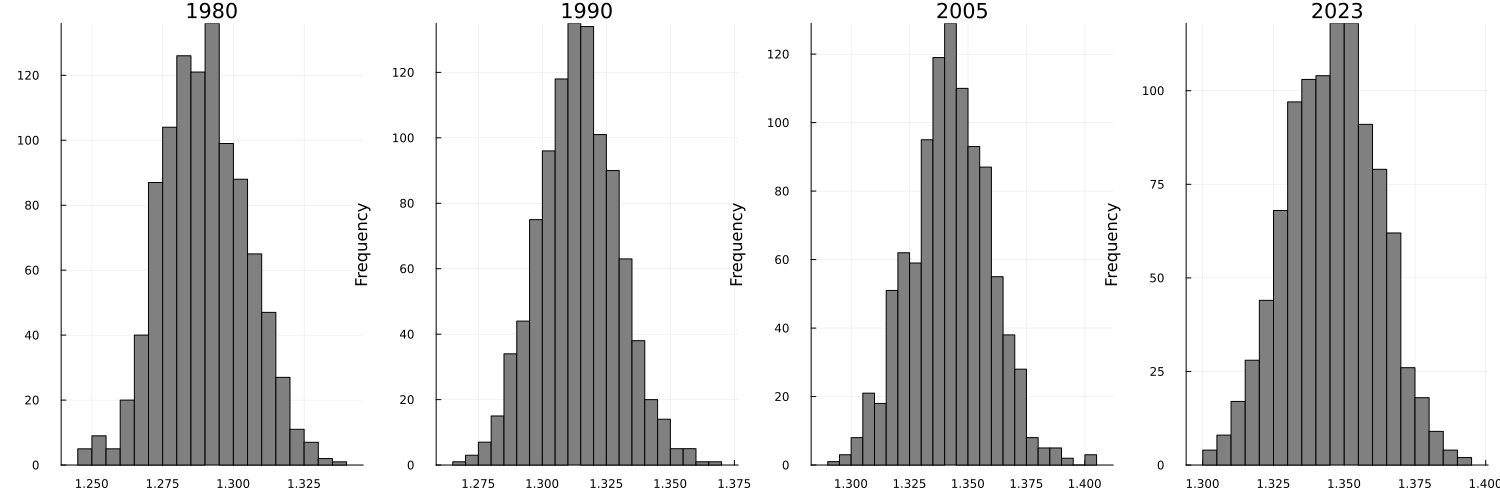

In [56]:
# Plot posterior distributions for several years of interest
years_of_interest = [1980, 1990, 2005, 2023]
idx = years_of_interest .- 1978

plots_array = []
for i in idx
    year = 1978 + i
    samples = vec(posterior_samples[i])
    p = Plots.histogram(samples,
                  bins=30,
                  xlabel="θ",
                  ylabel="Frequency",
                  title="$year",
                  legend=false,
                  color=:gray,
                  linecolor=:black)
    push!(plots_array, p)
end

Plots.plot(plots_array..., layout=(1, 4), size=(1500, 500))

Finally, we'll derive point estimates and credible intervals from our posterior samples, and plot them as a function of year:

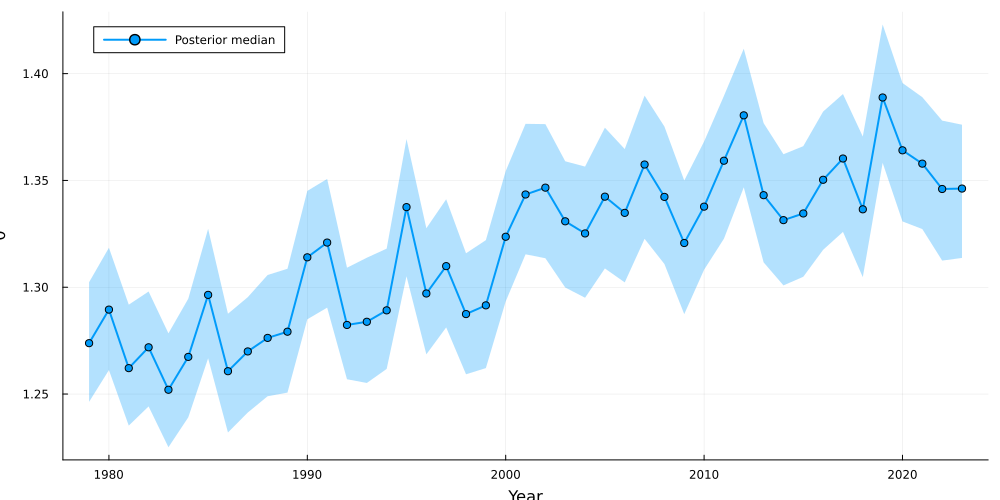

In [60]:
# Compute point estimates and 95% central credible intervals
years = 1979:2023
n_years = length(years)

estimates = zeros(n_years)
lower = zeros(n_years)
upper = zeros(n_years)

for i in 1:n_years
    samples = vec(posterior_samples[i])
    estimates[i] = median(samples)
    lower[i] = quantile(samples, 0.025)
    upper[i] = quantile(samples, 0.975)
end

# Plot point estimates and credible intervals as a function of year
Plots.plot(years, estimates,
     ribbon=(estimates .- lower, upper .- estimates),
     xlabel="Year",
     ylabel="θ̂",
     label="Posterior median",
     linewidth=2,
     fillalpha=0.3,
     marker=:circle,
     size=(1000, 500),
     legend=:topleft)

## References

Cressie, N. (1993). Statistics for Spatial Data, revised edition. Wiley, Hoboken, NJ.

Ising, E. (1925). Beitrag zur Theorie des Ferromagnetismus. PhD thesis, Universitat Hamburg, Hamburg, Germany.

Potts, R. B. (1952). Some generalized order-disorder transformations. Mathematical Proceedings of the Cambridge Philosophical Society, 48:106–109.

Rue, H. and Held, L. (2005). Gaussian Markov Random Fields: Theory and Applications. CRC Press, Boca Raton, FL.

Sainsbury-Dale, M., Zammit-Mangion, A., Cressie, N., Huser, R. 2025. Neural parameter estimation with incomplete data. [https://doi.org/10.48550/arXiv.2501.04330.](https://doi.org/10.48550/arXiv.2501.04330)

Swendsen, R. H. and Wang, J.-S. (1987). Nonuniversal critical dynamics in Monte Carlo simulations. Physical Review Letters, 58:86–88.

Zammit-Mangion, A., Sainsbury-Dale, M., and Huser, R. (2025). Neural methods for amortized inference. Annual Review of Statistics and Its Application, 12:311–335.